# Analyze and plot Divvy trips

In [13]:
%matplotlib inline
import sodapy
import matplotlib.pyplot as pp
import numpy as np

data_url = 'data.cityofchicago.org'
divvy_data = 'fg6s-gzvg'

## Example: Print most recent 10 trips for a bike

In [6]:
data = sodapy.Socrata(data_url, None)

bike_id = 2538  # random bike

# Get most recent 10 trips
trip_chain = data.get(divvy_data, bike_id=bike_id,
                      limit=10, order='stop_time DESC')

for t in trip_chain:
    print t['from_station_name'], ' >> ', t['to_station_name']

data.close()

Clark St & Randolph St  >>  Franklin St & Jackson Blvd
Desplaines St & Jackson Blvd  >>  Clark St & Randolph St
Franklin St & Quincy St  >>  Desplaines St & Jackson Blvd
Aberdeen St & Jackson Blvd  >>  Franklin St & Quincy St
Ada St & Washington Blvd  >>  Aberdeen St & Jackson Blvd
Desplaines St & Kinzie St  >>  Ada St & Washington Blvd
Noble St & Milwaukee Ave  >>  Desplaines St & Kinzie St
Western Ave & Winnebago Ave  >>  Noble St & Milwaukee Ave
Milwaukee Ave & Wabansia Ave  >>  Western Ave & Winnebago Ave
Larrabee St & Webster Ave  >>  Milwaukee Ave & Wabansia Ave


## Plot each trip as a line segment

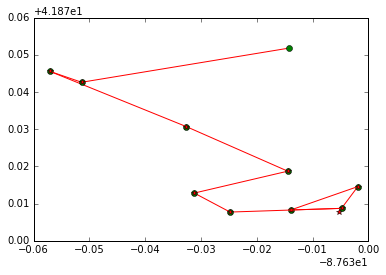

In [4]:
for t in trip_chain:
    from_lat = float(t['from_latitude'])
    to_lat = float(t['to_latitude'])
    from_lon = float(t['from_longitude'])
    to_lon = float(t['to_longitude'])
    
    pp.plot([from_lon, to_lon], [from_lat, to_lat], 'r')
    pp.plot(from_lon, from_lat, 'go')
    pp.plot(to_lon, to_lat, 'r*')
    
pp.show()

## Analyze trip chains
A trip chain is a series of contiguous trips (from station to station) where each trip starts at the same station as where the previous trip ended.

Trip chains are presumably disrupted for several reasons including
- Maintenance
- Removal for special events
- Load balancing

### Tripchain length for a random bike

Average tripchain length: 6.14


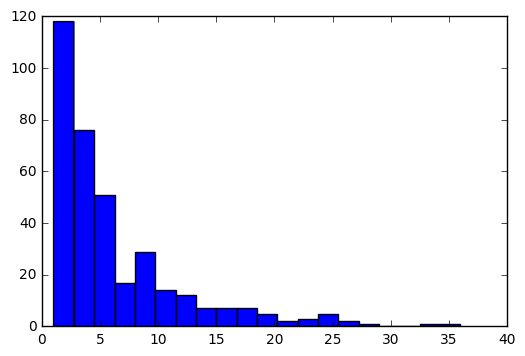

In [17]:
import tripchains
bike_id = 1000  # random bike

# Get all trips for bike, oldest first
data = sodapy.Socrata(data_url, None)
all_trips = data.get(divvy_data,
                     bike_id=bike_id,
                     limit=10000,
                     order='stop_time ASC')
data.close()

tc_starts = tripchains.tripchain_starts(all_trips)
tc_len = tripchains.tripchain_lengths(tc_starts, len(all_trips))

print 'Average tripchain length: {0:4.2f}'.format(np.mean(tc_len))

pp.hist(tc_len, bins=20)
pp.show()

### Analyze tripchains from many bikes (ensemble average)

Average tripchain length: 6.78
0.95 1.0 5.15018239178


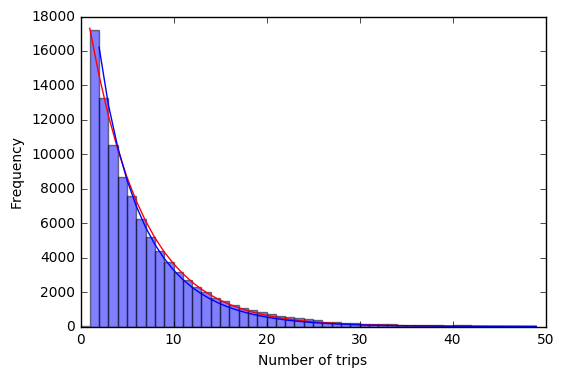

In [75]:
import scipy.stats
n_tc = 100000      # Number of tripchains to include in average
tc_len = [0]*n_tc  # Tripchain length

with open('tripchains.txt') as f:
    f.readline()  # Discard header row
    for i in range(n_tc):
        line = f.readline().split(',')
        tc_len[i] = int(line[1])
        
# Average statistics
print 'Average tripchain length: {:4.2f}'.format(np.mean(tc_len))

# Fit exponential distribution
# exponential statistics would be expected if bike removal is a Poisson process
exp_loc, exp_scale = scipy.stats.expon.fit(tc_len)
exp_dist = scipy.stats.expon(loc=exp_loc, scale=exp_scale)

# Fit Weibull distribution
wei_c, wei_loc, wei_scale = scipy.stats.dweibull.fit(tc_len, floc=1.0)
wei_dist = scipy.stats.dweibull(c=wei_c, loc=wei_loc, scale=wei_scale)
print wei_c, wei_loc, wei_scale

# Truncate histogram to 50 trips
pp.hist(tc_len, bins=range(50), alpha=0.5)
pp.plot(bins[1:], n_tc*exp_dist.pdf(bins[1:]), 'r')
pp.plot(bins[1:], 2*n_tc*wei_dist.pdf(bins[1:]), 'b')

pp.xlabel('Number of trips')
pp.ylabel('Frequency')
pp.show()